see: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

see: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

In [16]:
! pip install git+https://github.com/facebookresearch/segment-anything.git
! pip install torch torchvision opencv-python matplotlib
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/pip-req-build-bln_xyzk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/pip-req-build-bln_xyzk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Reshimming asdf python...
Reshimming asdf python...
--2024-07-22 20:20:53--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.9.95.59, 65.9.95.122, 65.9.95.119, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.9.95.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.3’

sam_vit_h_4b8939.pt  91%[

filename: kodim06.png


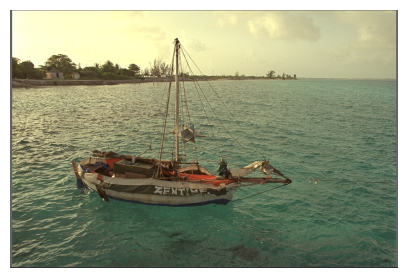

read in image


In [29]:
from pathlib import Path
import matplotlib.pyplot as plt
import random
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import numpy as np
import torch
import cv2
import sys
sys.path.append("..")


"""
read in random image
"""

filename =  f'kodim{random.randint(1, 24):02d}.png'
imgpath = Path.cwd().parent / 'kodak' / filename
assert imgpath.exists(), f'Image not found at {imgpath}'
image = cv2.imread(str(imgpath))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(f"filename: {filename}")

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()
print("read in image")


43
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
segmented background


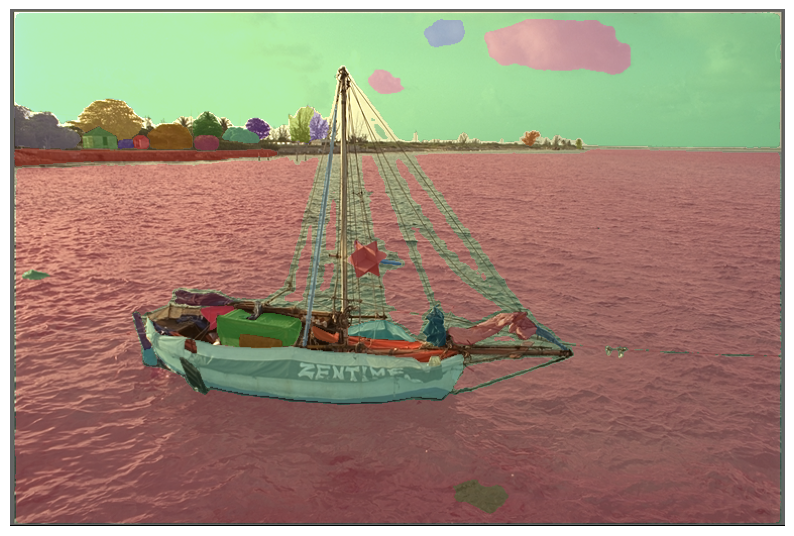

In [33]:
"""
segment background
"""

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

sam_checkpoint = "sam_vit_h_4b8939.pth" # vision transformer with hybrid architecture
model_type = "vit_h"
device = "cpu" # "cpu" or "cuda" (not "mps")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
# masks_generator = SamAutomaticMaskGenerator(model=sam)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # <- 
    pred_iou_thresh=0.99, # <-
    stability_score_thresh=0.99, # <-
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, # requires open-cv to run post-processing
)
masks = masks_generator.generate(image)
print(len(masks))
print(masks[0].keys())
print("segmented background")

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

combined masks


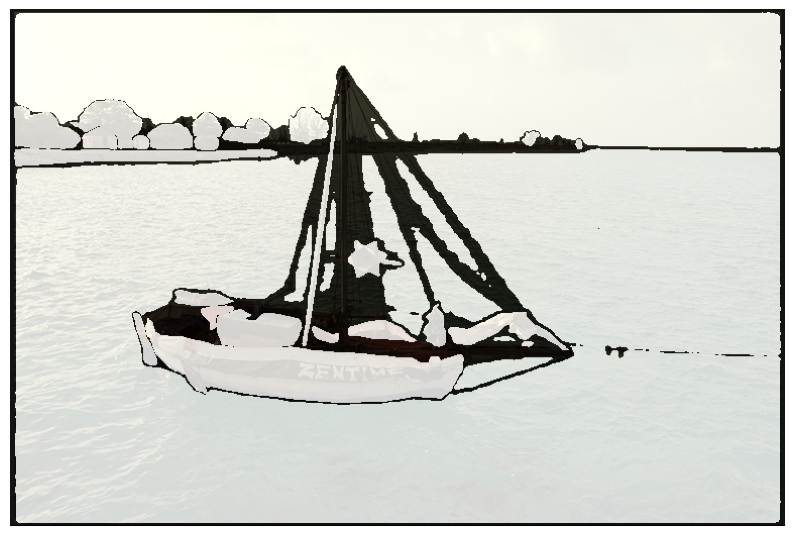

In [34]:
"""
combine masks
"""

combined_mask = np.zeros(image.shape[:2], dtype=bool)
for mask in masks:
    combined_mask = np.logical_or(combined_mask, mask['segmentation'])
print("combined masks")

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.imshow(combined_mask, alpha=0.8, cmap='gray')
plt.axis('off')
plt.show()


inverted combined mask


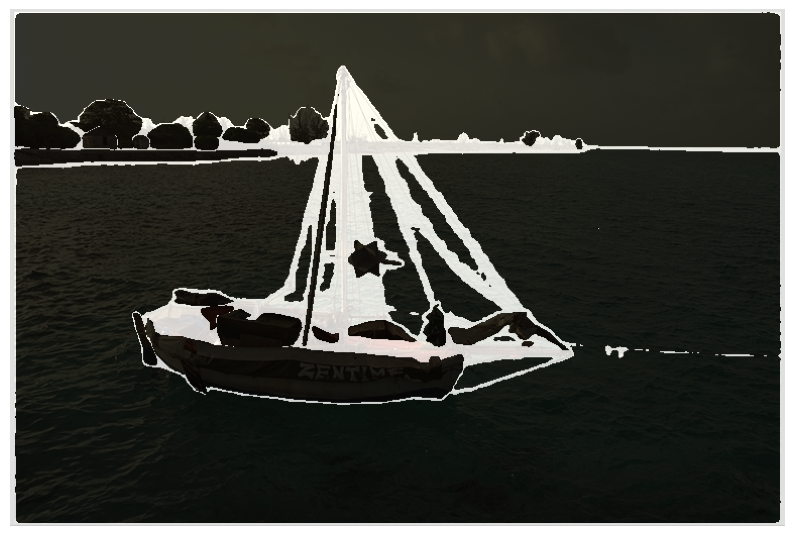

In [35]:
"""
visualize background
"""

background_mask = ~combined_mask
print("inverted combined mask")

plt.figure(figsize=(10,10))
plt.imshow(image)
# show_anns(masks)
plt.imshow(background_mask, alpha=0.8, cmap='gray')
plt.axis('off')
plt.show()
